# Project Overview [Phase 1]

This notebook demonstrates a deep learning classifier for the automatic detection of brown adipose tissue/brown fat(BAT) in FDG PET‑CT scans.

**Goals**

* Identify scans containing metabolically active BAT.
* Provide an assistive tool for radiologists/researchers.

**Outline**

1. Data loading: read DICOM scans and prepare paired labels.
2. Pre‑processing / augmentation: intensity normalisation, random flips/ etc.
3. Model: a ResNet‑50 backbone (ImageNet V2) trained on our dataset.
4. Training loop: standard supervised training with focal loss & class weighting
5. Inference utilities: to run the trained network on individual scans and test set
6. Evaluation metrics: e.g. Recall, F1, Precision, to determine model performance

In [ ]:
!pip install torch torchvision pydicom imageio numpy scikit-learn grad-cam opencv-python-headless matplotlib

# Brown Fat Uptake Classifier (PET/CT)

In [22]:
#!/usr/bin/env python3
"""
Brown Fat  Classifier (PET/CT DICOM)

trained a ResNet‑50 on ~500 PET/CT DICOM slices to predict:
  Brown fat uptake score (0 / 1 / 2 / 3)

DATA:
CSV must containcolumns:
    filename,brown_fat
Where filename is relative to dcm_root, brown_fat ∈ {0,1,2,3},

Dependencies:
  pip install torch torchvision pydicom imageio numpy scikit-learn
"""

import os
import csv
import argparse
from pathlib import Path
from typing import Optional
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import ExplicitVRLittleEndian
import tempfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from IPython.display import Image
import cv2
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

#from google.colab import drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


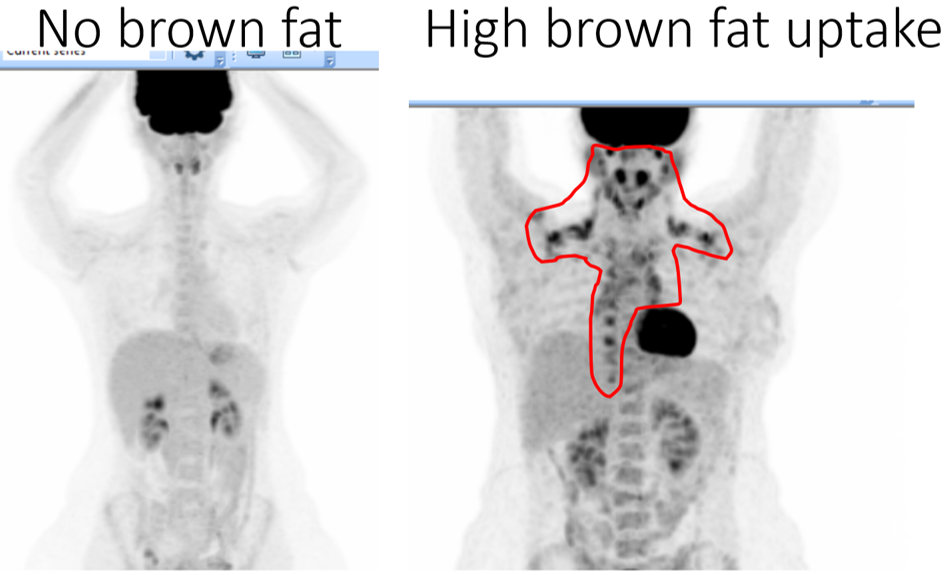

In [23]:

root_dir="content" # update as needed

#drive.mount('/content/drive')
#root_dir = "/content/drive/MyDrive/"

Image(os.path.join(root_dir, "dataset/bfexample.png"))

Brown fat is a harmless metabolically active fat that shows up more in colder weather. Uptake can be seen in the neck, lymph nodes, and upper spine on the right image (outlined in red). This can interfere with reading a scan as it can obfuscate actual malignancies.

In [24]:
class Args:
    data_csv = os.path.join(root_dir, "dataset/labels.csv")
    test_csv = os.path.join(root_dir, "dataset/labels_test.csv")
    dcm_root = os.path.join(root_dir, "dataset/dicoms")
    epochs = 30
    batch_size = 8
    out_dir = os.path.join(root_dir, "runs/exp1/")
    model = os.path.join(root_dir, "runs/exp1/best.pt")
    img_size = 224
    lr = 3e-4
    weight_decay = 1e-4
    num_workers = 0
    freeze_backbone = 5

arguments = Args()

## Dataset

Load 2D PET/CT DICOM files, assign labels, and expose them via a custom `torch.utils.data.Dataset` subclass ready for the DataLoader

In [25]:
class DicomDataset(Dataset):
    """Load DICOM files and associated labels"""

    def __init__(self, csv_file: str, dcm_root: str, transform=None):
        self.items = []  # list[(Path, int, ]  (file, brown_fat,)
        with open(csv_file) as f:
            reader = csv.DictReader(f)
            for row in reader:
                path = Path(dcm_root) / (row["filename"] + ".dcm")
                bf = int(row["brown_fat"])
                self.items.append((path, bf,))
        self.transform = transform

    # ----- helpers -----------------------------------------------------------
    def _load_dicom(self, fname: Path) -> np.ndarray:
        ds = pydicom.dcmread(str(fname))
        arr = ds.pixel_array.astype(np.float32).squeeze()
        #rescale -> 0‑255 (8‑bit)
        arr -= arr.min()
        arr /= (arr.max() + 1e-5)
        arr *= 255.0
        return arr.clip(0, 255).astype(np.uint8)

    # ----- torch.Dataset interface -----------------------------------------
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, bf = self.items[idx]

        img = self._load_dicom(path)

        # if single-channel, stack into RGB; otherwise leave
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        elif not (img.ndim == 3 and img.shape[2] == 3):
            raise ValueError(f"Unexpected DICOM shape {img.shape}")

        if self.transform:
            img = self.transform(img)
        target_bf = torch.tensor(bf, dtype=torch.long)
        return img, {"bf": target_bf}

## Transforms & Augmentation

Define training & validation transform pipelines. These include resizing to the network input size, PET/CT standardisation, and data augmentation techniques such as random rotation, horizontal flip, and normalisation.

In [26]:
def build_transforms(img_size: int = 224, train: bool = True):
    ops = [
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
    ]
    if train:
        ops += [transforms.RandomHorizontalFlip(), transforms.RandomRotation(10)]
    ops += [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    return transforms.Compose(ops)

## Model: A ResNet‑50 backbone

Implementation of the neural network architecture: a ResNet‑50 encoder pretrained on ImageNet

In [27]:
class ResNetBF(nn.Module):
    def __init__(self, num_bf: int = 4):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # remove single‑task head
        self.dropout = nn.Dropout(0.5)
        self.fc_bf = nn.Linear(in_features, num_bf)

    def forward(self, x):
        feat = self.backbone(x)
        feat = self.dropout(feat)
        return self.fc_bf(feat)

## Training / Evaluation routines

Set up the training loop (optimizer, scheduler, loss functions) and evaluation helpers for metrics like AUC and F1 score. Includes checkpointing.

In [28]:
def train(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    transform = build_transforms(args.img_size, train=True)
    dataset = DicomDataset(args.data_csv, args.dcm_root, transform)
    val_size = int(len(dataset) * 0.2)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

    model = ResNetBF().to(device)
    crit_bf = nn.CrossEntropyLoss()

    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    freeze_epochs = max(args.freeze_backbone, 0)
    if freeze_epochs:
        for p in model.backbone.parameters():
            p.requires_grad = False

    best_val = float('inf')
    os.makedirs(args.out_dir, exist_ok=True)

    for epoch in range(1, args.epochs + 1):
        if epoch == freeze_epochs + 1:
            for p in model.backbone.parameters():
                p.requires_grad = True
            print("Backbone unfrozen from epoch", epoch)

        model.train()
        running_loss = 0.0
        for img, targets in train_loader:
            img = img.to(device); bf_gt = targets["bf"].to(device)
            bf_logits= model(img)
            loss = crit_bf(bf_logits, bf_gt)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item() * img.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        val_loss = evaluate(model, val_loader, crit_bf, device)
        print(f"Epoch {epoch:02d}/{args.epochs} | train {train_loss:.4f} | val {val_loss:.4f}")
        scheduler.step()

        tries=6
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), Path(args.out_dir) / "best.pt")
            trigger= 0  # reset patience counter
        else:
            trigger += 1
            if trigger >= tries:
                print(f"No improvement for {trigger} epoch(s)")
                print("Early stopping triggered.")
                break

    print("Training complete. Best val loss:", best_val)

@torch.inference_mode()
def evaluate(model, loader, crit_bf, device):
    model.eval(); running_loss = 0.0
    for img, targets in loader:
        img = img.to(device); bf_gt = targets["bf"].to(device)
        bf_logits = model(img)
        running_loss += (crit_bf(bf_logits, bf_gt)).item() * img.size(0)
    return running_loss / len(loader.dataset)

## Inference & Test set functions

Utility functions to run inference on a single scan or an entire test directory

In [29]:
@torch.inference_mode()
def infer_single(model_path: str, dcm_file: str, img_size: int = 224):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = ResNetBF(); model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    transform = build_transforms(img_size, train=False)
    ds = pydicom.dcmread(dcm_file); img = ds.pixel_array.astype(np.float32)
    img = (img - img.min()) / (img.max() + 1e-5) * 255; img = img.clip(0, 255).astype(np.uint8)
    img = np.stack([img, img, img], axis=-1)
    img = transform(img).unsqueeze(0).to(device)
    bf_logits= model(img)
    bf_pred = torch.argmax(bf_logits, 1).item()
    return bf_pred

def test_set(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    transform = build_transforms(args.img_size, train=False)
    dataset = DicomDataset(args.test_csv, args.dcm_root, transform)
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
    model = ResNetBF(); model.load_state_dict(torch.load(args.model, map_location=device))
    model.to(device).eval()
    crit_bf = nn.CrossEntropyLoss()
    test_loss = evaluate(model, loader, crit_bf, device)
    print(f"Test loss: {test_loss:.4f}")

    total = 0
    bf_bin_correct = 0
    bf_4class_correct = 0
    path_correct = 0

    # helper for binary grouping
    def bf_bin(x): return 0 if x in (0,1) else 1

    with torch.inference_mode():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            bf_true = targets["bf"]

            logits_bf = model(imgs)
            preds_bf = torch.argmax(logits_bf, 1)


            for t, p in zip(bf_true, preds_bf):
                total += 1
                # binary
                if bf_bin(t) == bf_bin(p):
                    bf_bin_correct += 1
                # 4-class
                if t == p:
                    bf_4class_correct += 1


    print(f"Brown fat binary: {bf_bin_correct}/{total}")
    print(f"Brown fat 4-class: {bf_4class_correct}/{total}")

    all_preds = []
    all_targets = []
    for imgs, targets in loader:
        imgs = imgs.to(device)
        bf_true = targets["bf"]  # extract brown-fat labels only
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(bf_true.cpu().numpy())

    # Confusion matrix &metrics
    cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
    print("\nConfusion Matrix (4-class):")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, labels=[0, 1, 2, 3], digits=3))


In [30]:
# utility to visualize model activations using Grad-CAM.

def run_and_visualize_gradcam(model_path: str, dcm_file: str, img_size: int = 224):
    """
    Runs inference and visualizes the model's activation using Grad-CAM.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = ResNetBF()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    # load and preprocess image
    ds = pydicom.dcmread(dcm_file)
    img_for_viz = ds.pixel_array.astype(np.float32)
    img_for_viz = (img_for_viz - img_for_viz.min()) / (img_for_viz.max() + 1e-5)
    img_for_viz_resized = cv2.resize(img_for_viz, (img_size, img_size))
    rgb_img = np.stack([img_for_viz_resized] * 3, axis=-1)

    transform = build_transforms(img_size, train=False)

    img_uint8 = (img_for_viz * 255).clip(0, 255).astype(np.uint8)
    input_tensor__data = np.stack([img_uint8] * 3, axis=-1)
    input_tensor = transform(input_tensor__data).unsqueeze(0).to(device)

    bf_logits = model(input_tensor)
    bf_pred = torch.argmax(bf_logits, 1).item()
    print(f"Brown fat prediction: {bf_pred}")

    target_layers = [model.backbone.layer4[-1]]
    targets = [ClassifierOutputTarget(bf_pred)]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

## Run

Training takes approximately 10-30min on CPU and 1-5min on GPU. A trained model is already provided.

In [31]:
#train(arguments)
# ^ uncomment to train new model

A loss of \<0.6 is considered good. Random chance is ~1.3.
Binary considers only the presence of absence of brown fat uptake. 4-class considers four levels (no,low,med,high / 0,1,2,3).

In [32]:
test_set(arguments)


Test loss: 0.4329
Brown fat binary: 89/91
Brown fat 4-class: 84/91

Confusion Matrix (4-class):
[[80  1  0  0]
 [ 4  1  0  0]
 [ 2  0  1  0]
 [ 0  0  0  2]]

Classification Report:
              precision    recall  f1-score   support

           0      0.930     0.988     0.958        81
           1      0.500     0.200     0.286         5
           2      1.000     0.333     0.500         3
           3      1.000     1.000     1.000         2

    accuracy                          0.923        91
   macro avg      0.858     0.630     0.686        91
weighted avg      0.910     0.923     0.907        91



All poor scores for class 1 suggest difficulty distinguishing minimal levels of brown (i.e only in the neck, from 0). Perhaps binary classification would be more suitable (0,1 = 0; 2,3 = 3). However, weighted averages of > .9 show high overall performance.

Single file inference (for manual checking):

In [41]:
model_path = os.path.join(root_dir, "runs/exp1/best.pt")
dicom_file = os.path.join(root_dir, "dataset/dicoms/388.dcm")

bf_pred = infer_single(model_path, dicom_file, img_size=224)

print(f"Brown fat prediction: {bf_pred}")
#correct value for this file is 2

Brown fat prediction: 2


## Single File Inference with Grad-CAM

Visualize the model's focus for a single DICOM file.
The red areas highlight where the model 'looks' to make its classification.
The correct label for this example file is 2.

Brown fat prediction: 2


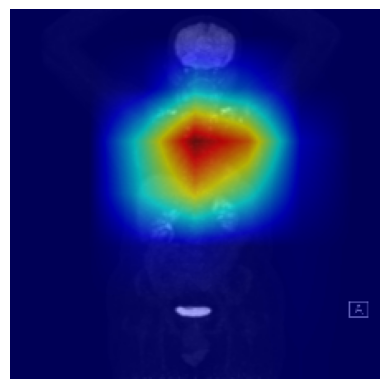

In [42]:
model_path = os.path.join(root_dir, "runs/exp1/best.pt")
dicom_file = os.path.join(root_dir, "dataset/dicoms/388.dcm")

run_and_visualize_gradcam(model_path, dicom_file, img_size=224)

# TESTING

In [50]:
#

print("--- Running Unit & Component Tests for Phase 1 ---")

# Test 1: DicomDataset._load_dicom function
try:
    # create a dummy DICOM file in memory

    file_meta = FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2' # CT Image Storage
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

    ds = Dataset()
    ds.file_meta = file_meta

    # Create a 64x64 image with values from 1000 to 5095
    pixel_data = np.arange(1000, 1000 + 64*64, dtype=np.uint16).reshape(64, 64)
    ds.Rows = pixel_data.shape[0]
    ds.Columns = pixel_data.shape[1]
    ds.PixelData = pixel_data.tobytes()
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15

    with tempfile.NamedTemporaryFile(suffix=".dcm", delete=True) as tf:
        pydicom.dcmwrite(tf.name, ds, enforce_file_format=True)

        # Instantiate dataset (though we only need the loader function)
        dataset_loader = DicomDataset(csv_file=arguments.data_csv, dcm_root=".")
        loaded_arr = dataset_loader._load_dicom(Path(tf.name))

        assert loaded_arr.dtype == np.uint8, "Test 1 FAILED: Incorrect data type."
        assert loaded_arr.shape == (64, 64), "Test 1 FAILED: Incorrect shape."
        assert loaded_arr.min() == 0, "Test 1 FAILED: Min value is not 0 after normalization."
        assert loaded_arr.max() == 255, "Test 1 FAILED: Max value is not 255 after normalization."
        print("Test 1 PASSED: DicomDataset._load_dicom correctly normalizes image.")

except Exception as e:
    print(f"Test 1 FAILED: {e}")


# Test 2: model forward pass
try:
    model = ResNetBF()
    # create a dummy input tensor: batch of 2 images, 3 channels, 224x224
    dummy_input = torch.randn(2, 3, 224, 224)
    output = model(dummy_input)

    assert output.shape == (2, 4), f"Test 2 FAILED: Incorrect output shape. Expected (2, 4), got {output.shape}"
    print("Test 2 PASSED: ResNetBF model forward pass is successful.")

except Exception as e:
    print(f"Test 2 FAILED: {e}")

print("-------------------------------------------------")

--- Running Unit & Component Tests for Phase 1 ---
Test 1 PASSED: DicomDataset._load_dicom correctly normalizes image.
Test 2 PASSED: ResNetBF model forward pass is successful.
-------------------------------------------------
